Today's topics:
* Feature representation
* Feature augmentation
* Feature selection

Loading a dataset:

In [ ]:
import pandas as pd

data = pd.read_csv('../datasets/elements.csv', index_col=0)
data.head()

This dataset has a combination of continuous labels and categorical features which will help us explore some nuances of feature representation.
It also contains some missing values that we will have to deal with.

# Representing categorical features

One of the first things we have to address before using these data for modeling is the categorical variables.

## Integer encoding

Let's take a look at the first categorical column, `STP Phase`:

In [ ]:
data['STP Phase'].value_counts()

Since there are only two possible values, we can represent this with a binary label using .

In [ ]:
data['STP Phase'].astype("category").cat.codes

Here's another way to achieve this result using `scikit-learn` functions:

In [ ]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(data['STP Phase'])

print(labels)

Once the `LabelEncoder` is fitted, you can obtain the original `str` with the `inverse_transform`:

In [ ]:
print(encoder.inverse_transform(labels))

Finally, you can use the `numpy.unique` function to achieve a similar result:

In [ ]:
import numpy as np

cat, labels = np.unique(data['STP Phase'], return_inverse=True)

print(cat)
print(labels)
print(cat[labels])

## One-hot encoding

Let's take a look at the next categorical column, `Natural Crystal Structure`:

In [ ]:
data['Natural Crystal Structure'].value_counts()

This presents a problem because there are many labels.
In principle, we can convert them to `int` codes like so:

In [ ]:
cat, labels = np.unique(data['Natural Crystal Structure'], return_inverse=True)

print(cat)
print(labels)
print(cat[labels])

However, this will be a problem when we use these features in a prediction task because it assumes *ordinality* (recall our discussion on classification labels).
We can investigate this problem below:

In [ ]:
from scipy.spatial import distance
from matplotlib import pyplot as plt

n = len(labels)
dist = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        dist[i, j] = np.abs(labels[i] - labels[j])

fig, ax = plt.subplots()
_ = ax.hist(dist.flatten())
_ = ax.set_xlabel('Distance')
_ = ax.set_ylabel('Frequency')

What you can see is that some pairs of crystal structures have large distances while others have small distances.
Here's another way to visualize this problem:

In [ ]:
from plotly import express as px

cat, labels = np.unique(data['Natural Crystal Structure'], return_inverse=True)

px.scatter(x=labels, y=np.random.rand(n), color=labels, hover_name=cat[labels])

Imagine using this space for a k-Neighbors regression problem.
The BCC and CUB phases would be grouped together while being far away from TET.
It is possible that there is some structure to this space, but we haven't provided it here.

The solution is to use *one-hot encoding*:

<img src="../lectures/assets/one_hot_encoding_diagram.jpg" width=600 alt="Diagram showing the transformation of a categorical 'Color' feature into multiple binary 'One-Hot' feature vectors">

In this scheme, each category gets its own "dummy feature" which is a binary vector indicating whether the observation falls into that category or not.
Let's see how to achieve this transformation and then look at the advantages.

In [ ]:
pd.get_dummies(data)

Here we have a bunch of columns concatenated onto the end that contain the one-hot encodings for each categorical variable.
Let's focus on only the `Natural Crystal Structure` features for now:

In [ ]:
# get the augmented DataFrame
data_one_hot = pd.get_dummies(data, columns=['Natural Crystal Structure'])

# drop the original features
n_features = data.shape[1]
data_one_hot = data_one_hot.iloc[:, n_features-1:]
data_one_hot

Now let's evaluate how this is different from the above `int`-based scheme:

In [ ]:
# convert to numpy array
features = data_one_hot.values.astype(int)

n = len(features)
dist = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        dist[i, j] = np.linalg.norm(features[i] - features[j])

fig, ax = plt.subplots()
_ = ax.hist(dist.flatten())
_ = ax.set_xlabel('Distance')
_ = ax.set_ylabel('Frequency')

Note that there are only two distances between different rows: 0 or $\sqrt{2}$.
This is because the features now live in a k-dimensional space where each label is equidistant from the others.
Here's a visualization:

In [ ]:
px.scatter_3d(x=features[:, 0], y=features[:, 3], z=features[:, 4], color=labels, hover_name=cat[labels])

## [Check your understanding]

Try utilizing the one-hot encodings in a regression model for one of the continuous features.
Compare the performance to the baseline case of excluding that categorical feature and the (incorrect) case of `int` label encoding.

In [ ]:
data.columns

In [ ]:
from sklearn import linear_model, model_selection


# baseline without categorical columns

x = data.dropna().drop(columns=['Ionization Energies (eV)'])
y = data.dropna().loc[:, 'Ionization Energies (eV)']

x = x.drop(columns=['STP Phase', 'Natural Crystal Structure'])
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, random_state=0)

model = linear_model.LinearRegression().fit(xtrain, ytrain)
print('no cat columns', model.score(xtest, ytest))

# with one-hot encodings
x = pd.get_dummies(data.dropna()).drop(columns=['Ionization Energies (eV)'])
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, random_state=0)
model = linear_model.LinearRegression().fit(xtrain, ytrain)
print('one-hot', model.score(xtest, ytest))

# with int encodings
x = data.dropna().drop(columns=['Ionization Energies (eV)'])
y = data.dropna().loc[:, 'Ionization Energies (eV)']

x['STP Phase'] = x['STP Phase'].astype('category').cat.codes
x['Natural Crystal Structure'] = x['Natural Crystal Structure'].astype('category').cat.codes
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, random_state=0)
model = linear_model.LinearRegression().fit(xtrain, ytrain)
print('int', model.score(xtest, ytest))

# Feature augmentation

Sometimes we may benefit from including additional features beyond those in the original dataset.
There are a few possible mechanisms that can lead to this being helpful:
* **Nonlinearity.** This is the main one. We already saw how linear models can learn nonlinear trends through the use of polynomial expansions. Introducing interactions such as products or quotients can lead to nonlinear behaviors in the original space being captured by simple linear relationships in the expanded feature space. We trade feature complexity for algorithmic simplicity.
* **Reduced dimensionality.** While nonlinear models can learn nonlinear relationships, it may be challenging on small datasets. If we know that the product of two features is an important variable, manually introducing a single feature that is the product of two others can reduce the dimensionality of the input features and therefore reduce the number of parameters that must be learned.

## Binning

Binning a continuous variable into discrete variables can enable nonlinear behaviors to be learned by linear models.
Let's consider the case of `Atomic Mass` versus `Ionization Energies (eV)`:

In [ ]:
x = data['Atomic Mass']
y = data['Ionization Energies (eV)']

fig, ax = plt.subplots()
_ = ax.plot(x, y, '.')

We can see there is a locally linear behavior with breaks between rows in the periodic table since atomic mass is similar within rows (periods) while ionization energy is similar within columns (groups).
Here is a visualization of the effect:

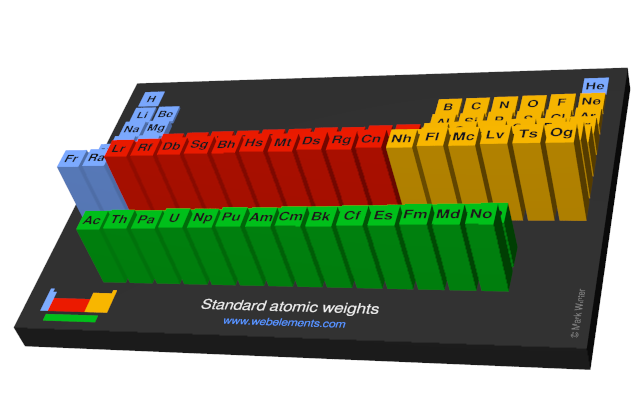

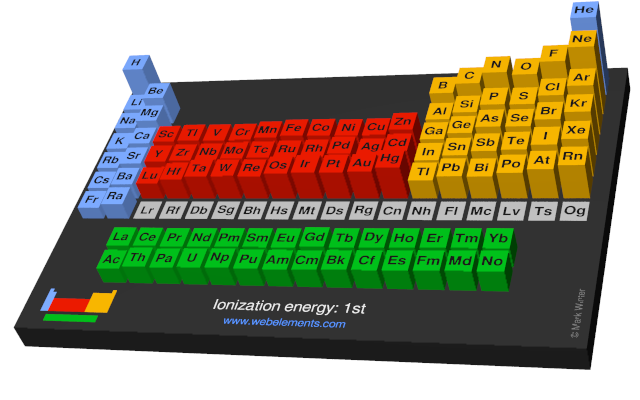

If we try to use linear regression here we will fail:

In [ ]:
from sklearn import linear_model, ensemble

x_arr = x.values.reshape(-1, 1)

model = linear_model.LinearRegression().fit(x_arr, y)
y_hat = model.predict(x_arr)
print( 'R2 = ', model.score(x_arr, y) )

fig, ax = plt.subplots()
_ = ax.plot(x, y, '.')
_ = ax.plot(x, y_hat, '.')

On the other hand, we can introduce a discrete variable that breaks the entire domain into smaller pieces:

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
mass_binned = discretizer.fit_transform(x_arr)

fig, ax = plt.subplots()
_ = ax.plot(x, mass_binned, '.')

With this new discrete variable, the behavior of the model will change:

In [ ]:
x_aug = np.hstack([x_arr, mass_binned])

model = linear_model.LinearRegression().fit(x_aug, y)
y_hat = model.predict(x_aug)
print( 'R2 = ', model.score(x_aug, y) )

fig, ax = plt.subplots()
_ = ax.plot(x, y, '.')
_ = ax.plot(x, y_hat, '.')

## [Exercise: Expert knowledge]

In the above case, we are using binning to approximate something like the group and period information in the periodic table.
There are often cases where "expert knowledge" can be infused to greatly improve the result.
Try introducing group and period information from [this periodic table dataset](https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee) to improve the performance of the Linear Regression model.

Follow these steps:
* Either download the file or fetch it with `requests`
* Load it with `pandas`
* Create new columns in our `data` DataFrame that include Period and Group
* Try fitting a Linear Regression model with this new data

In [ ]:
elements = pd.read_csv('../datasets/elements.csv', index_col='Symbol')
elements

In [ ]:
data['Period'] = [elements.loc[it, 'Period'] for it in data.index]
data['Group'] = [elements.loc[it, 'Group'] for it in data.index]

clean_data = data.dropna(subset=['Atomic Mass', 'Period', 'Group', 'Ionization Energies (eV)'])
x = clean_data.loc[:, ['Atomic Mass', 'Period', 'Group']]
y = clean_data.dropna(subset=['Atomic Mass', 'Period', 'Group', 'Ionization Energies (eV)']).loc[:, 'Ionization Energies (eV)']

fig, ax = plt.subplots()
_ = ax.plot(x['Atomic Mass'], y, '.')

model = linear_model.LinearRegression().fit(x, y)
y_hat = model.predict(x)
print( 'R2 = ', model.score(x, y) )

_ = ax.plot(x['Atomic Mass'], y_hat, '.')

## New dataset: 3d printing

In [ ]:
data = pd.read_csv('../datasets/3dprinting.csv')
data

We'll set up a regression problem to predict the surface roughness:

In [ ]:
x = data.loc[:, :'fan_speed (%)']
x = pd.get_dummies(x)  # convert categorical to one-hot!

y = data.loc[:, 'roughness (microns)']

Here is our baseline performance:

In [ ]:
model = linear_model.LinearRegression().fit(x, y)
print( 'R2 = ', model.score(x, y) )

## Interactions

We have already introduced the idea of polynomial features when we first learned about nonlinear regression.
These polynomial terms incorporate interactions between variables.

In [ ]:
from sklearn import preprocessing

poly = preprocessing.PolynomialFeatures(degree=2).fit(x)
print(poly.get_feature_names_out())

Let's see how these interacting features compare to the original ones:

In [ ]:
xp = poly.transform(x)
model = linear_model.LinearRegression().fit(xp, y)
model.score(xp, y)

Of course we're cheating here by not using a test set.
Let's fix that:

In [ ]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, test_size=0.20, shuffle=True, random_state=0)

model = linear_model.LinearRegression().fit(xtrain, ytrain)
print( model.score(xtest, ytest) )

model = linear_model.LinearRegression().fit(poly.transform(xtrain), ytrain)
print( model.score(poly.transform(xtest), ytest) )

We can evaluate the importance of these features using functions we developed last time:

In [ ]:
from sklearn import model_selection


def calc_rmse(y, y_pred):
    residuals = y - y_pred
    return np.sqrt(np.mean(residuals**2))


def permutation_importance(model, x, y, metric=calc_rmse):
    """Compute the permutation importance on a trained model."""
    baseline = metric(y, model.predict(x))

    permuted = np.zeros_like(x.columns)
    for i, col in enumerate(x.columns):
        x_permuted = x.copy()
        x_permuted[col] = np.random.permutation(x[col])
        permuted[i] = metric(y, model.predict(x_permuted))

    return baseline, permuted


def drop_column_importance(model, x, y, metric=calc_rmse):
    """Compute the drop-column importance on a trained model."""
    xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x, y, test_size=0.20, shuffle=True, random_state=0)

    model.fit(xtrain, ytrain)
    baseline = metric(ytest, model.predict(xtest))

    dropped = np.zeros_like(xtest.columns)
    for i, col in enumerate(xtest.columns):
        x_dropped_train = xtrain.copy().drop(columns=col)
        x_dropped_test = xtest.copy().drop(columns=col)
        model.fit(x_dropped_train, ytrain)
        dropped[i] = metric(ytest, model.predict(x_dropped_test))

    return baseline, dropped


model = linear_model.LinearRegression().fit(xtrain, ytrain)
baseline, permuted = permutation_importance(model, xtest, ytest)

baseline, dropped = drop_column_importance(linear_model.LinearRegression(), x, y)

And of course we should plot them to understand the result:

In [ ]:
fig, ax = plt.subplots()
ax.bar(x.columns, permuted, label='Permuted')
ax.set_xticklabels([it.split('(')[0].strip() for it in x.columns], rotation=90)
ax.hlines(baseline, 0, len(x.columns)-1, linestyles='dashed', label='Baseline')
ax.set_ylabel('Model RMSE')
ax.legend(loc='lower center')

fig, ax = plt.subplots()
ax.bar(x.columns, dropped, label='Dropped')
ax.set_xticklabels([it.split('(')[0].strip() for it in x.columns], rotation=90)
ax.hlines(baseline, 0, len(x.columns)-1, linestyles='dashed', label='Baseline')
ax.set_ylabel('Model RMSE')
ax.legend(loc='lower center')

# Automatic feature selection

## [Exercise: feature elimination]

Try iteratively (automatically) removing features using drop-column feature importance until a specific $k$ number of features are left.
Evaluate the performance each time.
Create a chart showing the performance with each number of features.

In [ ]:
def choose_worst_feature(model, x, y):
    baseline, dropped = drop_column_importance(model, x, y)
    return baseline, dropped, np.argmin(dropped)

def make_plot(x, dropped):
    fig, ax = plt.subplots()
    ax.bar(x.columns, dropped, label='Dropped')
    ax.set_xticklabels([it.split('(')[0].strip() for it in x.columns], rotation=90)
    ax.hlines(baseline, 0, len(x.columns)-1, linestyles='dashed', label='Baseline')
    ax.set_ylabel('Model RMSE')
    ax.legend(loc='lower center')

    return fig

x_trim = x.copy()
rmse = []

model = linear_model.LinearRegression()

for k in range(x_trim.shape[1]-1):
    baseline, dropped, worst = choose_worst_feature(model, x_trim, y)
    fig = make_plot(x_trim, dropped)
    rmse.append(baseline)
    print(x_trim.columns[worst])
    x_trim = x_trim.drop(columns=[x_trim.columns[worst]])

# print( x_trim.columns )

fig, ax = plt.subplots()
_ = ax.plot(rmse)

Augment the features with polynomial interaction terms.
Then repeat the exercise above.
> If done correctly, you should be able to use the same code!
Just change the input variable (features).

## Removing features with low variance

The most obvious thing to try is removing features that don't vary much.
You can imagine a corner case where a feature has zero variance (all the same value), where it obviously would not affect the output.

In [ ]:
from sklearn.feature_selection import GenericUnivariateSelect

selector = GenericUnivariateSelect(score_func='f_regression', mode='k_best', param=5)

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html) to try deploying this on the regression problem above.

## Sequential feature selection

Sequential Feature Selector (SFS) is a greedy search algorithm that evaluates the feature combinations in a forward direction and adds the most significant features one by one.
This type of algorithm is best suited for feature selection in instance-based algorithms, where the greedy search can be applied directly to the feature space.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

model = linear_model.LinearRegression().fit(xtrain, ytrain)
selector = SequentialFeatureSelector(model, n_features_to_select=5)

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to try deploying this on the regression problem above.

## Recursive feature elimination

Recursive Feature Elimination (RFE) is a backward elimination algorithm that removes the least important features recursively.
This type of algorithm is best for parametric models where features can interact.

In [ ]:
from sklearn.feature_selection import RFE

model = linear_model.LinearRegression()
selector = RFE(model, n_features_to_select=5, step=1)

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) to try deploying this on the regression problem above.